Hi again 

I know What to do now 

first let's Extract data and Store it in dataframe with label and images path

In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import clear_output
import time
import os
from skimage.filters import threshold_local
from skimage.morphology import skeletonize


In [2]:
dir_path = "./ORAND-CAR-2014/"
CAR_A_test_images_path = dir_path + 'CAR-A/a_test_images/'
CAR_A_train_images_path = dir_path + 'CAR-A/a_train_images/'
CAR_B_test_images_path = dir_path + 'CAR-B/b_test_images/'
CAR_B_train_images_path = dir_path + 'CAR-B/b_train_images/'

def load_original_images():
    images_path = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.png'):
                image_path = os.path.join(root, file)
                images_path.append(image_path.replace('\\','/'))
    return images_path
    
images_path = load_original_images()

def calculate_digit_count(label):
    return len(label)

def get_labels(image_dir,text_path):
  with open(text_path,'r') as f :
    lines = f.readlines()
  listt = []
  for line in lines :
    parts = line.strip().split("\t")
    listt.append([image_dir + parts[0],parts[1]])
  DF = pd.DataFrame(listt)
  DF = DF.rename(columns={0: 'image_path', 1: 'label'})
  return DF

def get_all_labels():
  CAR_A_test_text = dir_path + 'CAR-A/a_test_gt.txt'
  CAR_A_train_text = dir_path + 'CAR-A/a_train_gt.txt'
  CAR_B_test_text = dir_path + 'CAR-B/b_test_gt.txt'
  CAR_B_train_text = dir_path + 'CAR-B/b_train_gt.txt'
  a_test_label_df = get_labels(CAR_A_test_images_path,CAR_A_test_text)
  a_train_label_df = get_labels(CAR_A_train_images_path,CAR_A_train_text)
  b_test_label_df = get_labels(CAR_B_test_images_path,CAR_B_test_text)
  b_train_label_df = get_labels(CAR_B_train_images_path,CAR_B_train_text)
  all_labels = pd.concat([a_test_label_df , a_train_label_df , b_test_label_df , b_train_label_df],ignore_index=True)#.reset_index()
  return all_labels

def reset_data():
  all_labels = get_all_labels()
  print(len(all_labels))
  print(len(all_labels['image_path'].unique())) # no dupicate image name
  all_labels["actual_digit_count"] = all_labels["label"].astype(str).apply(calculate_digit_count)
  return all_labels

all_labels = reset_data()

11719
11719


In [3]:
def get_size_dataFrame(all_labels):
  height_list = []
  width_list = []
  for image_path in all_labels['image_path']:
    height = Image.open(image_path).height
    width = Image.open(image_path).width
    
    height_list.append(height)
    width_list.append(width)

  sizes_df = pd.DataFrame({'width':width_list,'height':height_list})
  return sizes_df

### let's go for segmentation

In [4]:
def plot_random_image(image_label_df,from_path):
    random.seed(42)
    indices = list(range(len(image_label_df)))
    random.shuffle(indices)

    for idx in indices[:10]+[21,22]:
        target_image = image_label_df[from_path][idx]
        print("label:", image_label_df['label'][idx])
        print("target:", target_image)
        image = mpimg.imread(target_image)
        plt.imshow(image)
        plt.show()
        time.sleep(2)
        clear_output(wait=True)

### first converting to grayscale

In [5]:
def convert_to_grayscale(df, from_path,new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        # Read the image in color (BGR format)
        img = cv2.imread(img_path)

        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Save the grayscale image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, gray_img)

    # Update the image paths in the DataFrame with the new grayscale image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df

### now denoising with GaussianBlur

In [6]:
def denoise_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        # Read the image in grayscale
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Apply Gaussian blur to denoise the image
        denoised_image = cv2.GaussianBlur(gray_img, (5, 5), 0)

        # Save the denoised image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, denoised_image)

    # Update the image paths in the DataFrame with the new denoised image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df

### another denoise with cv2.fastNlMeansDenoising

In [7]:
def denoise_images_fastnlmeans(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        # Read the grayscale image
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Denoise the grayscale image using fastNlMeansDenoising
        # Adjust the h, templateWindowSize, and searchWindowSize parameters for better denoising
        denoised_img = cv2.fastNlMeansDenoising(gray_img, None, h=10, templateWindowSize=7, searchWindowSize=21)

        # Save the denoised image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, denoised_img)

    # Update the image paths in the DataFrame with the new denoised image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df

### binarizing with local thresholding

In [8]:
def local_threshold_images(df, from_path, new_dir_path, block_size, offset):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        # Read the image in grayscale
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Perform local thresholding using the threshold_local method from skimage
        binary_img = threshold_local(gray_img, block_size, offset=offset, method='gaussian', mode='reflect', cval=0)

        # Convert the binary image to uint8 format (0 or 255)
        binary_img = (binary_img * 255).astype(np.uint8)

        # Save the binary image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, binary_img)

    # Update the image paths in the DataFrame with the new binary image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df


### now binarizing images

In [9]:
def binarize_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    for i, img_path in enumerate(df[from_path]):
        # Read the image in grayscale
        im = Image.open(img_path)
        im = np.array(im)

        # Apply binary thresholding using Otsu's method
        _, binary_im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Convert the binary image to PIL Image
        binary_im = Image.fromarray(binary_im)

        # Save the binary image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        binary_im.save(save_path)

    # Update the image paths in the DataFrame with the new binary image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]

    return df

### inverting images

In [10]:
def invert_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        # Read the binarized image
        bin_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Invert the image color using bitwise NOT operation
        inverted_img = cv2.bitwise_not(bin_img)
        
        # Save the inverted image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, inverted_img)
    
    # Update the image paths in the DataFrame with the new inverted image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df

### dilateing images

In [11]:
def dilate_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        # Read the inverted image
        inverted_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Define the kernel for dilation (a 3x3 kernel in this case)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        
        # Dilate the image to increase the thickness of each digit
        dilated_img = cv2.dilate(inverted_img, kernel, iterations=1)
        
        # Save the dilated image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, dilated_img)
    
    # Update the image paths in the DataFrame with the new dilated image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


### eroding images

In [12]:
def erode_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        # Read the inverted image
        inverted_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Define the kernel for erosion (a 3x3 kernel in this case)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        
        # Erode the image to reduce the thickness of each digit
        eroded_img = cv2.erode(inverted_img, kernel, iterations=1)
        
        # Save the eroded image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, eroded_img)
    
    # Update the image paths in the DataFrame with the new eroded image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


### thinning using skeletonize

In [13]:
def thin_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        # Read the inverted image
        inverted_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Binarize the image (needed for skeletonization)
        _, binary_img = cv2.threshold(inverted_img, 128, 255, cv2.THRESH_BINARY)
        
        # Perform skeletonization
        skeleton = skeletonize(binary_img / 255)
        
        # Convert the skeleton back to uint8 format
        thin_img = (skeleton * 255).astype(np.uint8)
        
        # Save the thinned image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, thin_img)
    
    # Update the image paths in the DataFrame with the new thinned image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


### contour-based thinning

In [14]:
def thin_images(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        # Read the inverted image
        inverted_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Binarize the image
        _, binary_img = cv2.threshold(inverted_img, 128, 255, cv2.THRESH_BINARY)
        
        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
        # Iterate through each contour and thin it
        for contour in contours:
            # Create a blank image to draw the contour
            contour_img = np.zeros_like(binary_img)
            cv2.drawContours(contour_img, [contour], -1, 255, thickness=cv2.FILLED)
            
            # Perform XOR operation to thin the contour
            binary_img = cv2.bitwise_xor(binary_img, contour_img)
        
        # Save the thinned image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, binary_img)
    
    # Update the image paths in the DataFrame with the new thinned image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


### edge detection with canny

In [15]:
def detect_edges_canny(df, from_path, new_dir_path, low_threshold, high_threshold):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    for i, img_path in enumerate(df[from_path]):
        # Read the image in grayscale
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply Canny edge detection
        edges = cv2.Canny(gray_img, low_threshold, high_threshold)
        
        # Save the edges image
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, edges)
    
    # Update the image paths in the DataFrame with the new edges image paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


### using MSER

In [16]:
def detect_digits_mser(df, from_path, new_dir_path, min_area=100, max_area=2000, max_variation=0.25, min_diversity=0.2):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    
    digits_counts = []
    for i, img_path in enumerate(df[from_path]):
        # Read the image in grayscale
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Initialize MSER detector
        mser = cv2.MSER_create(min_area=min_area, max_area=max_area, max_variation=max_variation, min_diversity=min_diversity)
        
        # Detect MSER regions
        regions, _ = mser.detectRegions(gray_img)
        
        # Filter regions based on size and aspect ratio
        digits_regions = []
        for region in regions:
            x, y, w, h = cv2.boundingRect(region)
            aspect_ratio = w / float(h)
            if 0.2 < aspect_ratio < 2.5 and min_area < w * h < max_area:
                digits_regions.append(region)
        
        # Draw and save the regions
        mser_img = gray_img.copy()
        for region in digits_regions:
            x, y, w, h = cv2.boundingRect(region)
            cv2.rectangle(mser_img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Save the image with MSER regions marked
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, mser_img)

        # Saving new digits count 
        digits_counts.append(len(digits_regions))

    # Update the image paths in the DataFrame with the new MSER images paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    df["digits_count"] = digits_counts
    return df

### using CCA for detecting Images

In [17]:
def detect_digits_cca(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    
    digits_counts = []
    for i, img_path in enumerate(df[from_path]):
        # Read the grayscale image
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Threshold the image to binarize it (you may need to adjust the threshold value)
        _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY_INV)
        
        # Perform connected component analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img)
        
        # Initialize the list to store the regions
        digits_regions = []
        
        # Iterate over the connected components
        for label in range(1, num_labels):
            left, top, width, height, area = stats[label]
            
            # Apply additional filtering based on the area and aspect ratio of the component
            min_area = 100  # Adjust this value based on your requirements
            max_area = 2000  # Adjust this value based on your requirements
            min_aspect_ratio = 0.2  # Adjust this value based on your requirements
            max_aspect_ratio = 2.5  # Adjust this value based on your requirements
            
            if min_area < area < max_area and min_aspect_ratio < width / height < max_aspect_ratio:
                digits_regions.append((left, top, width, height))
        
        # Draw and save the regions
        cca_img = gray_img.copy()
        for region in digits_regions:
            left, top, width, height = region
            cv2.rectangle(cca_img, (left, top), (left + width, top + height), (255, 0, 0), 2)
        
        # Save the image with CCA regions marked
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, cca_img)

        # Saving new digits count 
        digits_counts.append(len(digits_regions))

    # Update the image paths in the DataFrame with the new CCA images paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    df["digits_count"] = digits_counts
    return df

In [18]:
def separate_digits_with_vertical_lines(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    digit_column = []
    for i, img_path in enumerate(df[from_path]):
        # Read the image in grayscale
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        digit_count = 1
        # Create a copy of the image to apply changes
        modified_img = gray_img.copy()

        # Find columns with all pixel values equal to 0 and replace them with 0.5
        empty_columns = (gray_img.sum(axis=0) < 0)
        column_diff = empty_columns[1:] ^ empty_columns[:-1]  # Calculate the difference between consecutive empty columns using XOR
        column_diff = [10] + column_diff.tolist() + [10]  # Add padding to the differences to handle edge cases
        for idx, diff in enumerate(column_diff[:-1]):
            if diff == 1 and column_diff[idx + 1] == 1:  # Check if two consecutive columns are too close
                modified_img[:, idx] = 128  # Set the column to 0.5 (gray)
                # Draw a vertical line on the modified image
                cv2.line(modified_img, (idx, 0), (idx, gray_img.shape[0]), (0, 0, 255), 2)

        # Find the column sums of the binary image
        column_sums = modified_img.sum(axis=0)

        # Identify the columns where there are no pixel values with 1
        column_separator = [idx for idx, val in enumerate(column_sums) if val == 0]

        # Add the start and end column indices to the separators
        column_separator = [0] + column_separator + [gray_img.shape[1]]
        # Crop the individual digits using the separators
        for idx in range(len(column_separator) - 1):
            start_col = column_separator[idx]
            end_col = column_separator[idx + 1]

            # Crop and save the digit only if it is not empty and the width is greater than 10 pixels
            digit_img = gray_img[:, start_col:end_col]
            if not cv2.countNonZero(digit_img) == 0 and end_col - start_col > 0 and end_col+1 < modified_img.shape[1]:
                digit_count += 1
                modified_img[:, end_col+1] = 128 
        digit_column.append(digit_count)
        # Save the image with CCA regions marked (with lines added)
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, modified_img)
    df["digits_count"] = digit_column
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


In [19]:
def detect_digits_contours(df, from_path, new_dir_path, min_area=100, max_area=2000, min_aspect_ratio=0.2, max_aspect_ratio=2.5):
    try:
        os.makedirs(new_dir_path)
    except:
        pass

    digits_counts = []
    for i, img_path in enumerate(df[from_path]):
        # Read the image in grayscale
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Threshold the image to create a binary image
        _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on size and aspect ratio
        digits_contours = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)
            if min_area < w * h < max_area and min_aspect_ratio < aspect_ratio < max_aspect_ratio:
                digits_contours.append(contour)

        # Draw and save the contours
        contour_img = gray_img.copy()
        cv2.drawContours(contour_img, digits_contours, -1, (255, 0, 0), 2)

        # Save the image with contours marked
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, contour_img)

        # Saving new digits count
        digits_counts.append(len(digits_contours))

    # Update the image paths in the DataFrame with the new images paths
    df["digits_count"] = digits_counts
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    return df


In [20]:
def detect_digits_sift(df, from_path, new_dir_path):
    try:
        os.makedirs(new_dir_path)
    except:
        pass
    
    digits_counts = []
    sift = cv2.SIFT_create()
    
    for i, img_path in enumerate(df[from_path]):
        # Read the image in grayscale
        gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Detect keypoints and descriptors using SIFT
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        
        # Draw keypoints on the image
        sift_img = cv2.drawKeypoints(gray_img, keypoints, None)
        
        # Save the image with SIFT keypoints marked
        save_path = os.path.join(new_dir_path, f"{i:05d}.png")
        cv2.imwrite(save_path, sift_img)

        # Saving new digits count (you can adjust this based on the detected keypoints)
        digits_counts.append(len(keypoints))

    # Update the image paths in the DataFrame with the new SIFT images paths
    df[new_dir_path] = [os.path.join(new_dir_path, f"{i:05d}.png") for i in range(len(df))]
    df["digits_count"] = digits_counts
    return df

In [21]:
all_labels = reset_data()

11719
11719


## PLOT Images

label: 1000
target: ./inverted/00022.png


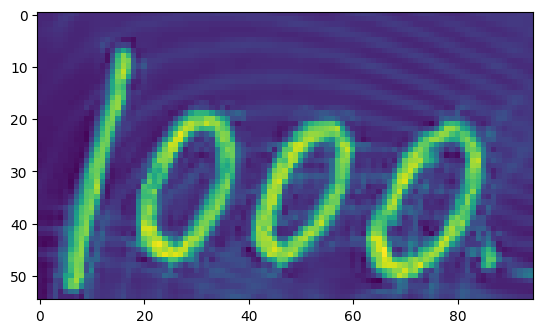

In [37]:
plot_random_image(all_labels,'./inverted/')

## Preproccesing

In [22]:
all_labels = convert_to_grayscale(all_labels,'image_path','./grayscaled/')

In [24]:
# all_labels = denoise_images(all_labels, 'image_path', './denoised/')
all_labels = denoise_images_fastnlmeans(all_labels, './grayscaled/', './denoised_fastnlmeans/')

In [36]:
# block_size = 9
# offset = 0
# all_labels = local_threshold_images(all_labels, './edges/', './local_thresholded/', block_size, offset)
all_labels = binarize_images(all_labels, './denoised_fastnlmeans/', './binarized/')
all_labels = invert_images(all_labels, './denoised_fastnlmeans/', './inverted/')

In [38]:
# all_labels = dilate_images(all_labels, './edges/', './dilated/')
all_labels = erode_images(all_labels, './inverted/', './eroded/')
all_labels = thin_images(all_labels, './inverted/', './thinned/')
all_labels = thin_images(all_labels, './inverted/', './c_thinned/')

In [26]:
low_threshold = 50
high_threshold = 150
all_labels = detect_edges_canny(all_labels, './denoised_fastnlmeans/', './edges/', low_threshold, high_threshold)

## Measuring

In [24]:
min_area = 300
max_area = 3000
max_variation = 0.5
min_diversity = 0.5
all_labels = detect_digits_mser(all_labels, './grayscaled/', './mser/', min_area, max_area, max_variation, min_diversity)

In [ ]:
all_labels = detect_digits_cca(all_labels, 'image_path', './cca/')

In [ ]:
all_labels = separate_digits_with_vertical_lines(all_labels, 'image_path', './vertical_lines/')

In [ ]:
min_area = 100
max_area = 2000
min_aspect_ratio = 0.2
max_aspect_ratio = 2.5
all_labels = detect_digits_contours(all_labels, 'image_path', './contours/', min_area, max_area, min_aspect_ratio, max_aspect_ratio)

In [ ]:
all_labels = detect_digits_sift(all_labels, 'image_path', './sift/')

In [25]:
correct_predictions = (all_labels["actual_digit_count"] == all_labels["digits_count"]).sum()
accuracy = correct_predictions / len(all_labels)
print("Correct:", correct_predictions, "\nAccuracy:", accuracy)

Correct: 389 
Accuracy: 0.033193958528884716


In [25]:
all_labels.head()

,image_path,label,actual_digit_count,./grayscaled/,./local_thresholded/,./denoised_fastnlmeans/
0,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1500,4,./grayscaled/00000.png,./local_thresholded/00000.png,./denoised_fastnlmeans/00000.png
1,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,5743,4,./grayscaled/00001.png,./local_thresholded/00001.png,./denoised_fastnlmeans/00001.png
2,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1056,4,./grayscaled/00002.png,./local_thresholded/00002.png,./denoised_fastnlmeans/00002.png
3,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1000,4,./grayscaled/00003.png,./local_thresholded/00003.png,./denoised_fastnlmeans/00003.png
4,./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007...,1000,4,./grayscaled/00004.png,./local_thresholded/00004.png,./denoised_fastnlmeans/00004.png


In [ ]:
hi